По причение невозможности загрузки изображений Jupiter Notebook в пактикуме, делал проект в Google Colab

Прекод
Сборный проект-4
Вам поручено разработать демонстрационную версию поиска изображений по запросу.

Для демонстрационной версии нужно обучить модель, которая получит векторное представление изображения, векторное представление текста, а на выходе выдаст число от 0 до 1 — покажет, насколько текст и картинка подходят друг другу.

0.1  Описание данных
Данные доступны по ссылке.

В файле train_dataset.csv находится информация, необходимая для обучения: имя файла изображения, идентификатор описания и текст описания. Для одной картинки может быть доступно до 5 описаний. Идентификатор описания имеет формат <имя файла изображения>#<порядковый номер описания>.

В папке train_images содержатся изображения для тренировки модели.

В файле CrowdAnnotations.tsv — данные по соответствию изображения и описания, полученные с помощью краудсорсинга. Номера колонок и соответствующий тип данных:

Имя файла изображения.
Идентификатор описания.
Доля людей, подтвердивших, что описание соответствует изображению.
Количество человек, подтвердивших, что описание соответствует изображению.
Количество человек, подтвердивших, что описание не соответствует изображению.
В файле ExpertAnnotations.tsv содержатся данные по соответствию изображения и описания, полученные в результате опроса экспертов. Номера колонок и соответствующий тип данных:

Имя файла изображения.
Идентификатор описания.
3, 4, 5 — оценки трёх экспертов.

Эксперты ставят оценки по шкале от 1 до 4, где 1 — изображение и запрос совершенно не соответствуют друг другу, 2 — запрос содержит элементы описания изображения, но в целом запрос тексту не соответствует, 3 — запрос и текст соответствуют с точностью до некоторых деталей, 4 — запрос и текст соответствуют полностью.

В файле test_queries.csv находится информация, необходимая для тестирования: идентификатор запроса, текст запроса и релевантное изображение. Для одной картинки может быть доступно до 5 описаний. Идентификатор описания имеет формат <имя файла изображения>#<порядковый номер описания>.

В папке test_images содержатся изображения для тестирования модели.

1  1. Исследовательский анализ данных
Наш датасет содержит экспертные и краудсорсинговые оценки соответствия текста и изображения.

В файле с экспертными мнениями для каждой пары изображение-текст имеются оценки от трёх специалистов. Для решения задачи вы должны эти оценки агрегировать — превратить в одну. Существует несколько способов агрегации оценок, самый простой — голосование большинства: за какую оценку проголосовала большая часть экспертов (в нашем случае 2 или 3), та оценка и ставится как итоговая. Поскольку число экспертов меньше числа классов, может случиться, что каждый эксперт поставит разные оценки, например: 1, 4, 2. В таком случае данную пару изображение-текст можно исключить из датасета.

Вы можете воспользоваться другим методом агрегации оценок или придумать свой.

В файле с краудсорсинговыми оценками информация расположена в таком порядке:

Доля исполнителей, подтвердивших, что текст соответствует картинке.
Количество исполнителей, подтвердивших, что текст соответствует картинке.
Количество исполнителей, подтвердивших, что текст не соответствует картинке.
После анализа экспертных и краудсорсинговых оценок выберите либо одну из них, либо объедините их в одну по какому-то критерию: например, оценка эксперта принимается с коэффициентом 0.6, а крауда — с коэффициентом 0.4.

Ваша модель должна возвращать на выходе вероятность соответствия изображения тексту, поэтому целевая переменная должна иметь значения от 0 до 1.

In [166]:
#!wget https://code.s3.yandex.net/datasets/dsplus_integrated_project_4.zip

In [167]:
#!unzip dsplus_integrated_project_4.zip

In [168]:
#!pip list
#!pip install torch  1.10.0
#!pip3 install "torchvision==0.14.0"
!pip install scikit-learn pandas nltk
!pip install torchvision

import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import GroupShuffleSplit
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, Dropout
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import TimeSeriesSplit, GridSearchCV
from sklearn.metrics import f1_score

#Модули для векторизации изображений
import torch
import torch.nn as nn
import torchvision.models as models
from torchvision import transforms
from PIL import Image
import os

#Модули для векторизации текста
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from sklearn.feature_extraction.text import TfidfVectorizer

In [169]:
from sklearn.metrics import make_scorer, mean_squared_error, mean_absolute_error
from sklearn.linear_model import LinearRegression, LogisticRegression
import numpy as np
import tensorflow as tf
import tensorflow as keras
#import tensor as tf
np.random.seed(0)

 1 Загружаем обучающие данные

In [170]:
#Тренировочный датасет
data = pd.read_csv('/content/to_upload/train_dataset.csv')
data.head(1)

,image,query_id,query_text
0,1056338697_4f7d7ce270.jpg,2549968784_39bfbe44f9.jpg#2,A young child is wearing blue goggles and sitt...


In [171]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5822 entries, 0 to 5821
Data columns (total 3 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   image       5822 non-null   object
 1   query_id    5822 non-null   object
 2   query_text  5822 non-null   object
dtypes: object(3)
memory usage: 136.6+ KB


In [172]:
data_images = pd.read_csv('/content/to_upload/test_images.csv')
data_images.head(5)

,image
0,3356748019_2251399314.jpg
1,2887171449_f54a2b9f39.jpg
2,3089107423_81a24eaf18.jpg
3,1429546659_44cb09cbe2.jpg
4,1177994172_10d143cb8d.jpg


#### Обработка краудсорсиновых данных

In [173]:
data_crown_annotations = pd.read_csv('/content/to_upload/CrowdAnnotations.tsv',sep='\t', header=None, names=['image', 'query_id', 'all', 'positive', 'negative'])
data_crown_annotations.info(2)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 47830 entries, 0 to 47829
Data columns (total 5 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   image     47830 non-null  object 
 1   query_id  47830 non-null  object 
 2   all       47830 non-null  float64
 3   positive  47830 non-null  int64  
 4   negative  47830 non-null  int64  
dtypes: float64(1), int64(2), object(2)
memory usage: 1.8+ MB


In [174]:
#Добавим результирующий столбец. Если стреднее значение превышает 0.4, то ститаем описание верным.
data_crown_annotations['result'] = data_crown_annotations.apply(lambda x: 0 if x['all'] < 0.4 else 1, axis=1)

In [175]:
#Кол-во утвердительных описаний
d = data_crown_annotations[data_crown_annotations['result'] == 1].shape[0] / data_crown_annotations.shape[0]
print(f'Количество утверд. коммнтариев: {data_crown_annotations[data_crown_annotations["result"] == 1].shape[0]}')
print(f'Процент от общего количества комментариев: {d}')

Количество утверд. коммнтариев: 2739
Процент от общего количества комментариев: 0.057265314656073596


In [176]:
data_crown_annotations.head(2)

,image,query_id,all,positive,negative,result
0,1056338697_4f7d7ce270.jpg,1056338697_4f7d7ce270.jpg#2,1.0,3,0,1
1,1056338697_4f7d7ce270.jpg,114051287_dd85625a04.jpg#2,0.0,0,3,0


#### Обработка данных от экспертов

In [177]:
#оценка экспертов
data_expert = pd.read_csv('/content/to_upload/ExpertAnnotations.tsv',sep='\t', header=None, names=['image', 'query_id', '1', '1.1', '1.2'])
data_expert.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5822 entries, 0 to 5821
Data columns (total 5 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   image     5822 non-null   object
 1   query_id  5822 non-null   object
 2   1         5822 non-null   int64 
 3   1.1       5822 non-null   int64 
 4   1.2       5822 non-null   int64 
dtypes: int64(3), object(2)
memory usage: 227.5+ KB


In [178]:
# Фунция получения итогового результата голосования
def expert_result(a, b, c):  #голоса каждого эксперта
  d = (a/4+b/4+c/4)/3
  return (1 if d > 0.6 else 0)

Среднее значение больше 0.6 принимаем как верное описение картинки.

In [179]:
# Добавляем столбец с итоговым решение по описанию 0 или 1
data_expert['result'] = data_expert.apply(lambda x: expert_result(x['1'], x['1.1'], x['1.2']), axis=1)
data_expert.head(2)

,image,query_id,1,1.1,1.2,result
0,1056338697_4f7d7ce270.jpg,2549968784_39bfbe44f9.jpg#2,1,1,1,0
1,1056338697_4f7d7ce270.jpg,2718495608_d8533e3ac5.jpg#2,1,1,2,0


In [180]:
# количество утвердительных описаний
print(f'Количествоутверд. коммнтариев: {data_expert[data_expert["result"] == 1].shape[0]}')
print(f'Процент от общего количества комментариев: {d}')

Количествоутверд. коммнтариев: 816
Процент от общего количества комментариев: 0.057265314656073596


Объеденим достоверные данные краудсорсинга и экспертов.
Данные экспертов будем считать приоритетными в случае оценки одной и той же картинки.

In [181]:
len(list(data_crown_annotations['image'].unique())) #количество уникальных картинок

1000

In [182]:
unic_image_expert = list(data_expert['image'].unique()) #список уникальных картинок от экспертов
print(len(unic_image_expert))


1000


Будем работать с данными от экспертов. Данные краусорсинга не учитываем.

In [183]:
data_expert.head(2)

,image,query_id,1,1.1,1.2,result
0,1056338697_4f7d7ce270.jpg,2549968784_39bfbe44f9.jpg#2,1,1,1,0
1,1056338697_4f7d7ce270.jpg,2718495608_d8533e3ac5.jpg#2,1,1,2,0


Добавим текст описания к датасету, очитстим от получившихся пропусков.

In [184]:
data_expert = data_expert.merge(data, left_on=['image','query_id'], right_on=['image', 'query_id'], how='left')

data_expert.head(2)

,image,query_id,1,1.1,1.2,result,query_text
0,1056338697_4f7d7ce270.jpg,2549968784_39bfbe44f9.jpg#2,1,1,1,0,A young child is wearing blue goggles and sitt...
1,1056338697_4f7d7ce270.jpg,2718495608_d8533e3ac5.jpg#2,1,1,2,0,A girl wearing a yellow shirt and sunglasses s...


In [185]:
data_expert = data_expert.drop(['query_id', '1', '1.1', '1.2'], axis=1)
data_expert.head(2)

,image,result,query_text
0,1056338697_4f7d7ce270.jpg,0,A young child is wearing blue goggles and sitt...
1,1056338697_4f7d7ce270.jpg,0,A girl wearing a yellow shirt and sunglasses s...


## 2. Проверка данных

В некоторых странах, где работает ваша компания, действуют ограничения по обработке изображений: поисковым сервисам и сервисам, предоставляющим возможность поиска, запрещено без разрешения родителей или законных представителей предоставлять любую информацию, в том числе, но не исключительно тексты, изображения, видео и аудио, содержащие описание, изображение или запись голоса детей. Ребёнком считается любой человек, не достигший 16 лет.

В вашем сервисе строго следуют законам стран, в которых работают. Поэтому при попытке посмотреть изображения, запрещённые законодательством, вместо картинок показывается дисклеймер:

> This image is unavailable in your country in compliance with local laws
>

Однако у вас в PoC нет возможности воспользоваться данным функционалом. Поэтому все изображения, которые нарушают данный закон, нужно удалить из обучающей выборки.

Удалим все что связано с детьми

In [186]:
#функция определения наличия запрещенных слов в описании картинки
def word_in_str(text):
  stop_word = ['babe', 'child', 'kid', 'infant', 'brant', 'wean', 'bairn']
  for i in text.split(' '):
    if i in stop_word:
      return 1
  return 0

In [187]:
#Разметим датасет на разоешенные и запрещенные описания.
#Запрещенные описания удаляем
#Не нужные столбцы также удаляем
data_expert['to_dellete'] = data_expert.apply(lambda x: word_in_str(x['query_text']), axis=1)
data_expert = data_expert.loc[data_expert['to_dellete']==0]
data_expert = data_expert.drop(['to_dellete'], axis=1)
data_expert.shape

(5558, 3)

In [188]:
#Данные перед векторизацией
data_expert.head(2)

,image,result,query_text
1,1056338697_4f7d7ce270.jpg,0,A girl wearing a yellow shirt and sunglasses s...
2,1056338697_4f7d7ce270.jpg,0,A man sleeps under a blanket on a city street .


## 3. Векторизация изображений

Перейдём к векторизации изображений.

Самый примитивный способ — прочесть изображение и превратить полученную матрицу в вектор. Такой способ нам не подходит: длина векторов может быть сильно разной, так как размеры изображений разные. Поэтому стоит обратиться к свёрточным сетям: они позволяют "выделить" главные компоненты изображений. Как это сделать? Нужно выбрать какую-либо архитектуру, например ResNet-18, посмотреть на слои и исключить полносвязные слои, которые отвечают за конечное предсказание. При этом можно загрузить модель данной архитектуры, предварительно натренированную на датасете ImageNet.

Полуение вектора изображений

In [189]:
weights = 'ResNet18_Weights.IMAGENET1K_V1'
resnet = models.resnet18(pretrained=True)
for param in resnet.parameters():
    param.requires_grad_(False)

modules = list(resnet.children())[:-2]
resnet = nn.Sequential(*modules)

resnet.eval()

norm = transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])

preprocess = transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        norm,
    ])

#Функция создания вектора изображения
def image_to_tenzor(img):
    image_tensor = preprocess(img)
    return resnet(image_tensor.unsqueeze(0)).flatten()


/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [190]:
ROOT_PATH = '/content/to_upload/'
images = data_expert.image.unique()
tenzors_image = []
images_orders = []
query_tenzor = {}    # Создадим словарь {имя_картинки: тензор}

for i, image in enumerate(images):
  if i % 100 == 0:
    print(f'Processed {i} images')
  path = os.path.join(ROOT_PATH, 'train_images', image)
  images_orders.append(image)
  img = Image.open(path)
  tenzor = image_to_tenzor(img)  #получаем вектор изображения
  query_tenzor[image]=tenzor.numpy()
  tenzors_image.append(tenzor)

Processed 0 images
Processed 100 images
Processed 200 images
Processed 300 images
Processed 400 images
Processed 500 images
Processed 600 images
Processed 700 images
Processed 800 images
Processed 900 images


In [191]:
#Функция добавления вектора в датафрейм
def add_tenzor(image_name, tenzor_dict):
  for i in tenzor_dict:
    if image_name==i:
      return tenzor_dict[image_name]

In [192]:
data_expert['image_vector'] = data_expert.apply(lambda x: add_tenzor(x['image'], query_tenzor), axis=1) #Добавляем целевой признак
data_expert.head(1)

,image,result,query_text,image_vector
1,1056338697_4f7d7ce270.jpg,0,A girl wearing a yellow shirt and sunglasses s...,"[1.4565353, 1.4629921, 0.0037892463, 0.0, 0.0,..."


In [193]:
#Проверяем как выглядит вектор картинки
data_expert['image_vector'][1]

array([1.4565353 , 1.4629921 , 0.00378925, ..., 0.        , 0.        ,
       0.        ], dtype=float32)

## 4. Векторизация текстов

Следующий этап — векторизация текстов. Вы можете поэкспериментировать с несколькими способами векторизации текстов:

- tf-idf
- word2vec
- \*трансформеры (например Bert)

\* — если вы изучали трансформеры в спринте Машинное обучение для текстов.

In [194]:
nltk.download('punkt')
nltk.download('stopwords')

stop_words = set(stopwords.words('english'))

# Функция форматирования текса перед векторизацией
def preprocess_text(text):
    tokens = word_tokenize(text.lower())
    filtered_tokens = [word for word in tokens if word.isalnum() and word not in stop_words]
    return ' '.join(filtered_tokens)

# Замена старых описаний на изменненные
data_expert['query_text'] = data_expert['query_text'].apply(preprocess_text)


# Создание вектора текста
vectorizer = TfidfVectorizer()
vectors = vectorizer.fit_transform(data_expert['query_text'].tolist()).toarray()
data_expert['query_text_vector'] = [vect for vect in vectors]

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [195]:
data_expert = data_expert.drop(['query_text'], axis=1) #Удаляем описание, боьше не нужно. Вместо него теперь вектор.

## 5. Объединение векторов

Подготовьте данные для обучения: объедините векторы изображений и векторы текстов с целевой переменной.

In [196]:
#Итоговый датасет
data_expert.head(2)

,image,result,image_vector,query_text_vector
1,1056338697_4f7d7ce270.jpg,0,"[1.4565353, 1.4629921, 0.0037892463, 0.0, 0.0,...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
2,1056338697_4f7d7ce270.jpg,0,"[1.4565353, 1.4629921, 0.0037892463, 0.0, 0.0,...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."


In [197]:
data_expert['image_vector'] = np.array(data_expert['image_vector'])

In [198]:
data_expert['image_vector'][1]

array([1.4565353 , 1.4629921 , 0.00378925, ..., 0.        , 0.        ,
       0.        ], dtype=float32)

Объединяем массивы.

In [199]:
#Размер будущей матрицы.
shape_needed = data_expert.iloc[:, 2].shape[0], data_expert.iloc[:, 2].values[0].shape[0] + data_expert.iloc[:, 3].values[0].shape[0]

In [200]:
v = np.zeros(shape_needed)
v.shape

(5558, 26472)

In [201]:
col_image = 2 #Номер столбца вектора изображения
col_text = 3  #Номер столбца вектора текста
image_width = data_expert.iloc[:, 2].values[0].shape[0] #Размер вектора изображения

for i in range(data_expert.shape[0]):
  v[i, :image_width] = data_expert.iloc[i, col_image]     #поэлементно добавляю вектор изображения
  v[i, image_width:] = data_expert.iloc[i, col_text]      #дальше поэлементно добавляю к нему вектор текста, т.к. не смог победить вложенные массивы при concatinate и append

In [202]:
data_expert.iloc[:, 2].values[0]

array([1.4565353 , 1.4629921 , 0.00378925, ..., 0.        , 0.        ,
       0.        ], dtype=float32)

In [203]:
data_expert.iloc[:, 3].values[0].shape

(1384,)

In [204]:
#Соединяем вектор изображения и вектор текста.
data_expert.loc[:, 'vector'] = [a for a in np.concatenate([[x for x in data_expert.iloc[:,2].values], [x for x in data_expert.iloc[:,3].values]], axis=1)]

In [205]:
#Создаем отдельно признаки для модели преобразованные в тензор
X = tf.convert_to_tensor(v)

In [206]:
#Создаем отдельно массив целевого признака
y = data_expert.result.values

Пришлось разделить на отдельные массивы признаки и целевой признак, т.к. не смог победить вложенные массивы после преобразования в тензор.

## 6. Обучение модели предсказания соответствия

Для обучения разделите датасет на тренировочную и тестовую выборки. Простое случайное разбиение не подходит: нужно исключить попадание изображения и в обучающую, и в тестовую выборки.
Для того чтобы учесть изображения при разбиении, можно воспользоваться классом [GroupShuffleSplit](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.GroupShuffleSplit.html) из библиотеки sklearn.model_selection.

Код ниже разбивает датасет на тренировочную и тестовую выборки в пропорции 7:3 так, что строки с одинаковым значением 'group_column' будут содержаться либо в тестовом, либо в тренировочном датасете.

```
from sklearn.model_selection import GroupShuffleSplit
gss = GroupShuffleSplit(n_splits=1, train_size=.7, random_state=42)
train_indices, test_indices = next(gss.split(X=df.drop(columns=['target']), y=df['target'], groups=df['group_column']))
train_df, test_df = df.loc[train_indices], df.loc[test_indices]

```

Какую модель использовать — выберите самостоятельно. Также вам предстоит выбрать метрику качества либо реализовать свою.

In [207]:
#Деление на train и test.
gss = GroupShuffleSplit(n_splits=1, train_size=.7, random_state=42)
# train_indices, test_indices = next(gss.split(X=data_expert.drop(columns=['result']), y=data_expert['result'], groups=data_expert['image']))
train_indices, test_indices = next(gss.split(X=X, y=y, groups=data_expert['image']))
# train_df, test_df = data_expert.iloc[train_indices], data_expert.iloc[test_indices]
X_train, y_train, X_test, y_test = tf.gather(X, train_indices), y[train_indices], tf.gather(X, test_indices), y[test_indices]

In [208]:

#def join_vector(tensor_image, tensor_text):
  #x = tf.convert_to_tensor(tensor_text, np.float32)

  #y = tensor_image
  #return tf.keras.layers.Concatenate()([y, x])
  #return np.concatenate((tensor_image,tensor_text))
#X_train['image_vector'][0].eval(b)
#tf.convert_to_tensor(data_np, np.float32)

In [209]:
X_test

<tf.Tensor: shape=(1648, 26472), dtype=float64, numpy=
array([[0.        , 0.        , 0.        , ..., 0.33052689, 0.        ,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       ...,
       [0.        , 0.        , 0.01437235, ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.        , 0.01437235, ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.        , 0.01437235, ..., 0.        , 0.        ,
        0.        ]])>

#### Линейная регресия

In [210]:
tscv = TimeSeriesSplit(n_splits=5)

In [211]:
scoring={'mse': make_scorer(mean_squared_error)}

In [212]:
(len(X_train),)

(3910,)

In [213]:
X_train.shape[0]

3910

In [214]:
def create_model(input_shape):
    model = Sequential()
    model.add(Dense(1, input_shape=input_shape, activation='sigmoid'))
    model.compile(optimizer='sgd', loss='binary_crossentropy',
                  metrics=['accuracy'])

    return model

def train_model(model, features_train, target_train, features_test, target_test, batch_size=32, epochs=5,
               steps_per_epoch=None, validation_steps=None):

    #features_train, target_train = train_data
    #features_test, target_test = test_data
    model.fit(features_train, target_train,
              validation_data=(features_test, target_test),
              batch_size=batch_size, epochs=epochs,
              steps_per_epoch=steps_per_epoch,
              validation_steps=validation_steps,
              verbose=2, shuffle=True)

    return model

In [215]:
model = create_model(input_shape=(X_train.shape[1], ))
train_model(model, X_train, y_train, X_test, y_test)

/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/5
123/123 - 1s - 12ms/step - accuracy: 0.7703 - loss: 8.2903 - val_accuracy: 0.1402 - val_loss: 55.2027
Epoch 2/5
123/123 - 1s - 5ms/step - accuracy: 0.7857 - loss: 7.5348 - val_accuracy: 0.1644 - val_loss: 28.5025
Epoch 3/5
123/123 - 1s - 7ms/step - accuracy: 0.8043 - loss: 5.6444 - val_accuracy: 0.8598 - val_loss: 16.2799
Epoch 4/5
123/123 - 1s - 11ms/step - accuracy: 0.8151 - loss: 5.0225 - val_accuracy: 0.8598 - val_loss: 13.9784
Epoch 5/5
123/123 - 1s - 10ms/step - accuracy: 0.8059 - loss: 5.6573 - val_accuracy: 0.8604 - val_loss: 6.3297


<Sequential name=sequential_4, built=True>

#### Полносвязная нейронная сеть

In [216]:
def create_model(lr_adam):
    model = Sequential()
    model.add(Dense(512, activation='relu'))
    model.add(Dropout(0.5))  # Для регуляризации
    model.add(Dense(256, activation='relu'))
    model.add(Dropout(0.5))
    model.add(Dense(128, activation='relu'))
    model.add(Dropout(0.5))

    model.add(Dense(1, activation='sigmoid'))

    optimizer = Adam(learning_rate=lr_adam)
    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

    return model

def train_model(model, features_train, target_train, features_test, target_test, batch_size=32, epochs=5,
               steps_per_epoch=None, validation_steps=None):

    if steps_per_epoch is None:
        steps_per_epoch = len(features_train)
    if validation_steps is None:
        validation_steps = len(features_test)

    model.fit(features_train, target_train,
              validation_data=(features_test, target_test),
              batch_size=batch_size, epochs=epochs,
              steps_per_epoch=steps_per_epoch,
              validation_steps=validation_steps,
              verbose=2, shuffle=True)

    return model

In [217]:
n_model=create_model(0.001)
train_model(n_model, X_train, y_train, X_test, y_test)

Epoch 1/5


/usr/lib/python3.10/contextlib.py:153: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(typ, value, traceback)


3910/3910 - 39s - 10ms/step - accuracy: 0.7570 - loss: 3.9520 - val_accuracy: 0.8598 - val_loss: 0.4163
Epoch 2/5
3910/3910 - 39s - 10ms/step - accuracy: 0.7777 - loss: 0.8735 - val_accuracy: 0.8598 - val_loss: 0.5040
Epoch 3/5
3910/3910 - 42s - 11ms/step - accuracy: 0.8304 - loss: 0.5619 - val_accuracy: 0.8598 - val_loss: 0.5114
Epoch 4/5
3910/3910 - 40s - 10ms/step - accuracy: 0.8386 - loss: 0.4956 - val_accuracy: 0.8598 - val_loss: 0.4861
Epoch 5/5
3910/3910 - 41s - 10ms/step - accuracy: 0.8471 - loss: 0.4623 - val_accuracy: 0.8598 - val_loss: 0.4688


<Sequential name=sequential_5, built=True>

In [218]:
X_test.shape

TensorShape([1648, 26472])

In [219]:
X_test[0] == X_test[1]

<tf.Tensor: shape=(26472,), dtype=bool, numpy=array([ True,  True,  True, ..., False,  True,  True])>

Нейронная сеть показала лучше результат, чем модель линейной регрессии.

## 7. Тестирование модели

Настало время протестировать модель. Для этого получите эмбеддинги для всех тестовых изображений из папки `test_images`, выберите случайные 10 запросов из файла `test_queries.csv` и для каждого запроса выведите наиболее релевантное изображение. Сравните визуально качество поиска.

In [220]:
#Загружем описания. Выбираем 10 случайных.
df_test = pd.read_csv('/content/to_upload/test_queries.csv', sep='|')
df_test.head(2)

,Unnamed: 0,query_id,query_text,image
0,0,1177994172_10d143cb8d.jpg#0,"Two blonde boys , one in a camouflage shirt an...",1177994172_10d143cb8d.jpg
1,1,1177994172_10d143cb8d.jpg#1,Two boys are squirting water guns at each other .,1177994172_10d143cb8d.jpg


In [221]:
df_ten_img = df_test[['query_text']].sample(n=10)
df_ten_img = df_ten_img.reset_index()
df_ten_img.head(2)

,index,query_text
0,90,A boy plays basketball .
1,254,There are several people watching a person in ...


In [222]:
#Получаем вектора описаний
vectors = vectorizer.transform(df_ten_img['query_text'].tolist()).toarray()
df_ten_img['text_vector'] = [vect for vect in vectors]
df_ten_img.head(2)

,index,query_text,text_vector
0,90,A boy plays basketball .,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
1,254,There are several people watching a person in ...,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."


In [223]:
#Загружаем тестовые фото
ROOT_PATH = '/content/to_upload/'
images = df_test.image.unique()
tenzors_image = []
images_orders = []
query_tenzor = {}    # Создадим словарь {имя_картинки: тензор}

for i, image in enumerate(images):
  if i % 10 == 0:
    print(f'Processed {i} images')
  path = os.path.join(ROOT_PATH, 'test_images', image)
  images_orders.append(image)
  img = Image.open(path)
  tenzor = image_to_tenzor(img)  #получаем вектор изображения
  query_tenzor[image]=tenzor.numpy()
  tenzors_image.append(tenzor)

Processed 0 images
Processed 10 images
Processed 20 images
Processed 30 images
Processed 40 images
Processed 50 images
Processed 60 images
Processed 70 images
Processed 80 images
Processed 90 images


In [224]:
#Получаем вектора всех изображений
df_test['image_vector'] = df_test.apply(lambda x: add_tenzor(x['image'], query_tenzor), axis=1) #Добавляем целевой признак
df_test.head(1)

,Unnamed: 0,query_id,query_text,image,image_vector
0,0,1177994172_10d143cb8d.jpg#0,"Two blonde boys , one in a camouflage shirt an...",1177994172_10d143cb8d.jpg,"[0.41090876, 0.48567685, 1.8899, 1.4742956, 1...."


In [225]:
#Функция создания признаков к каждому вектору_картинки+вектор_описания
def vector_img_text(text, data_image):                                                                  #функция принимает одно описание и создает пару этого описания с каждым изображением
  shape_needed = data_image.iloc[:, 4].shape[0], data_image.iloc[:, 4].values[0].shape[0] + len(text)   #Размер будущей матрицы.
  ve = np.zeros(shape_needed)
  ve.shape

  col_image = 4 #Номер столбца вектора изображения
  # col_text = 2  #Номер столбца вектора текста
  image_width = data_image.iloc[:, 4].values[0].shape[0] #Размер вектора изображения
  for i in range(data_image.shape[0]):
    ve[i, :image_width] = data_image.iloc[i, col_image] #добавлаем поэлементно вектор изображения
    change_len = image_width
    for j in text:     #поэлементно добавляю вектор изображения
      ve[i][change_len] = j
      change_len+=1
  return ve

In [227]:
#Функция получает вектор описания и делает прогноз для всех картинок
#Картинка выбирается по лучшему предсказанию
def text_to_image(model, text_vector, data_image):                  #text_vector - передается одно описание
  vect = vector_img_text(text_vector, data_image)                   #data_image - передается датафрейм со списком векторов ихображений
  vect =tf.convert_to_tensor(vect)

  predition = n_model.predict(vect)                                 #предсказываем

  predition = np.array(predition)
  image = np.array(data_image['image'])

  df = pd.DataFrame({'image_query': image})                         #Создаем общий датафрейм для сортировки
  df['prediction'] = predition
  df = df.sort_values('prediction', ascending=False)                #Сортируем от лучшего к худшему
  df = df.reset_index()
  #print(df)
  return df['image_query'][0]

In [228]:
text_to_image(n_model, df_ten_img['text_vector'][0], df_test)

16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 31ms/step


'345785626_9fa59f38ce.jpg'

A boy plays basketball .
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 36ms/step


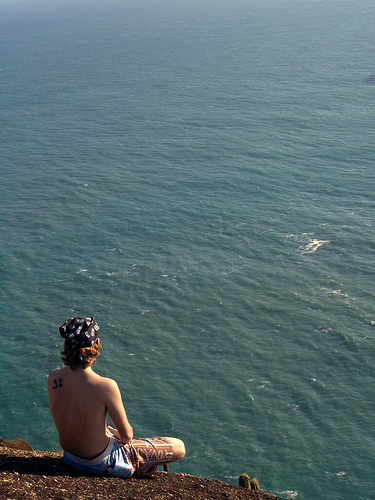

In [229]:
#Цикл for не выводит изображения на каждом этапе итерации, поэтому описания буду передавть вручную
print(df_ten_img['query_text'][0])
name_image = text_to_image(n_model, df_ten_img['text_vector'][0], df_test)
im = Image.open('/content/to_upload/test_images/'+name_image)
im


There are several people watching a person in the air with skies surrounded by mountains and snow .
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step


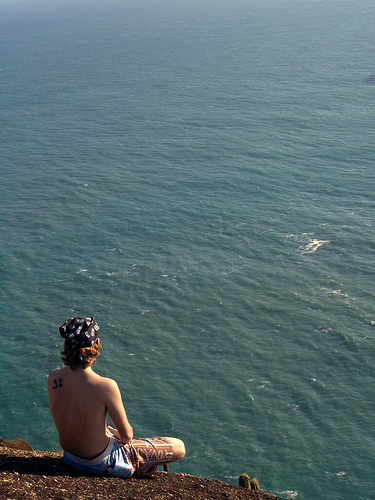

In [230]:
print(df_ten_img['query_text'][1])
name_image = text_to_image(n_model, df_ten_img['text_vector'][1], df_test)
im = Image.open('/content/to_upload/test_images/'+name_image)
im

A brown and white dog walks in the snow with a big chunk of snow in his mouth .
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step


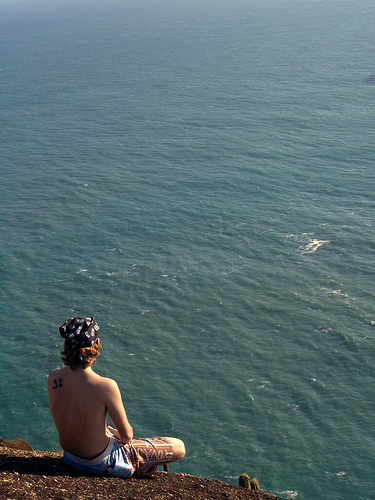

In [231]:
print(df_ten_img['query_text'][2])
name_image = text_to_image(n_model, df_ten_img['text_vector'][2], df_test)
im = Image.open('/content/to_upload/test_images/'+name_image)
im

Модель не смогла точно подбирать изображения соответсвующие описаниям